# Homomorphic Encryption in CNN Based Intrusion Detection System for Internet of Vehicles 
This is the code for the paper entitled "**Homomorphic Encryption in CNN Based Intrusion Detection System for Internet of Vehicles**"
Authors: Ronilson Candido do Nascimento (ronilson.nascimento@laccan.ufal.br), Douglas Moura (douglas.moura@dcc.ufmg.br) and André Aquino (alla@laccan.ufal.br)  
Organization: Instituto de Computação - Universidade Federal de Alagoas (UFAL); Departamento de Ciência da Computação Universidade Federal de Minas Gerais (UFMG)

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp;  Encryption parameters
&nbsp;  Read the dataset  
&nbsp;  Transform the tabular data into images  
&nbsp;  Display the transformed images  
&nbsp;  Split the training and test set  

## Import libraries

In [ ]:
import seal
from seal import EncryptionParameters, SEALContext, KeyGenerator, Encryptor, Evaluator, Decryptor, CKKSEncoder, CoeffModulus, Plaintext, Ciphertext
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Setup CKKS encryption parameters


In [2]:
poly_modulus_degree = 8192
scale = pow(2.0, 40)

In [ ]:
# Create encryption parameters
params = EncryptionParameters(seal.SchemeType.ckks)
params.set_poly_modulus_degree(poly_modulus_degree)
params.set_coeff_modulus(CoeffModulus.Create(poly_modulus_degree, [60, 40, 60]))

In [ ]:
# Create context
context = SEALContext(params)

In [ ]:
# Key generation
keygen = KeyGenerator(context)
public_key = keygen.public_key()
secret_key = keygen.secret_key()
relin_keys = keygen.relin_keys()

In [ ]:
# Encryption, evaluation, and decryption
encryptor = Encryptor(context, public_key)
decryptor = Decryptor(context, secret_key)
evaluator = Evaluator(context)
encoder = CKKSEncoder(context)

## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

In [ ]:
#Read dataset
df=pd.read_csv('data/Car_Hacking_5%.csv')

In [12]:
df

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,1201,41,39,39,35,0,0,0,154,R
1,809,64,187,127,20,17,32,0,20,R
2,1349,216,0,0,136,0,0,0,0,R
3,1201,41,39,39,35,0,0,0,154,R
4,2,0,0,0,0,0,3,2,228,R
...,...,...,...,...,...,...,...,...,...,...
818435,848,5,32,52,104,117,0,0,12,R
818436,1088,255,0,0,0,255,134,9,0,R
818437,848,5,32,100,104,117,0,0,92,R
818438,1349,216,90,0,137,0,0,0,0,R


In [13]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df.Label.value_counts()

Label
R        701832
RPM       32539
gear      29944
DoS       29501
Fuzzy     24624
Name: count, dtype: int64

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [14]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [15]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [16]:
df.describe()

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7]
count,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000,818440.000000
mean,126.301144,114.961191,107.611334,88.346055,110.140272,105.780186,112.303171,84.880830,92.908534
std,73.428712,90.511200,93.172628,99.451301,103.724310,95.647747,90.974640,101.280462,100.106442
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.217718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,120.097598,128.776276,114.737237,0.000000,131.201201,129.031532,129.797297,0.000000,0.000000
75%,188.888889,194.759760,192.462462,196.546547,191.058559,193.355856,190.292793,191.824324,191.058559
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


All features are in the same scale of [0,255]

### Generate images for each class

In [17]:
df0=df[df['Label']=='R'].drop(['Label'],axis=1)
df1=df[df['Label']=='RPM'].drop(['Label'],axis=1)
df2=df[df['Label']=='gear'].drop(['Label'],axis=1)
df3=df[df['Label']=='DoS'].drop(['Label'],axis=1)
df4=df[df['Label']=='Fuzzy'].drop(['Label'],axis=1)

In [ ]:
# Function to encrypt a single image (assuming grayscale images)
def encrypt_image(image, encoder, encryptor, scale):
    encrypted_pixels = []
    flat_image = image.flatten()  
    plain = Plaintext()
    
    # Encode and encrypt each pixel value
    encoder.encode(flat_image.tolist(), scale, plain)
    encrypted = Ciphertext()
    encryptor.encrypt(plain, encrypted)
    
    return encrypted

In [ ]:
# Function to decrypt an image
def decrypt_image(encrypted_image, decryptor, encoder, scale, image_shape):
    plain = Plaintext()
    decryptor.decrypt(encrypted_image, plain)
    decoded = []
    encoder.decode(plain, decoded)
    
    # Reshape the decoded data back to the image shape
    decrypted_image = np.array(decoded).reshape(image_shape)
    return decrypted_image

In [ ]:
# Generate some images from the dataset
images = generate_images_from_df(df0, num_images=5)

In [ ]:
# Encrypt the images
encrypted_images = []
for img in images:
    encrypted_img = encrypt_image(img, encoder, encryptor, scale)
    encrypted_images.append(encrypted_img)

In [ ]:
# Decrypt one of the images to verify
decrypted_img = decrypt_image(encrypted_images[0], decryptor, encoder, scale, images[0].shape)


In [18]:
# Generate 9*9 color images for class 0 (Normal)
count=0
ims = []

image_path = "train/0/"
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=27: 
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [19]:
# Generate 9*9 color images for class 1 (RPM spoofing)
count=0
ims = []

image_path = "train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=27: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [20]:
# Generate 9*9 color images for class 2 (Gear spoofing)
count=0
ims = []

image_path = "train/2/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=27: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [21]:
# Generate 9*9 color images for class 3 (DoS attack)
count=0
ims = []

image_path = "train/3/"
os.makedirs(image_path)


for i in range(0, len(df3)):  
    count=count+1
    if count<=27: 
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [22]:
# Generate 9*9 color images for class 4 (Fuzzy attack)
count=0
ims = []

image_path = "train/4/"
os.makedirs(image_path)


for i in range(0, len(df4)):  
    count=count+1
    if count<=27: 
        im=df4.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(9,9,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

## Split the training and test set 

In [23]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

29228


In [24]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [25]:
# The size of test set
Numbers

5845

In [26]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [27]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [28]:
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [29]:
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing


### Display samples for each category

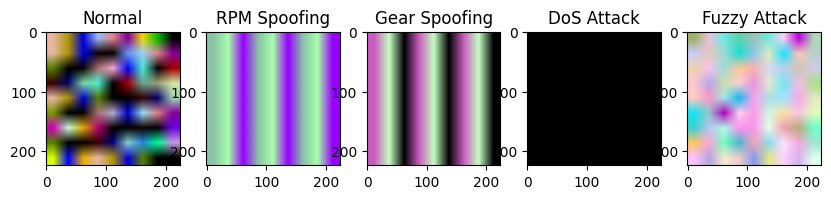

In [30]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
img1 = Image.open('./train_224/0/27.png')
img2 = Image.open('./train_224/1/83.png')
img3 = Image.open('./train_224/2/27.png')
img4 = Image.open('./train_224/3/27.png')
img5 = Image.open('./train_224/4/27.png')

plt.figure(figsize=(10, 10)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("RPM Spoofing")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Gear Spoofing")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("DoS Attack")
plt.subplot(1,5,5)
plt.imshow(img5)
plt.title("Fuzzy Attack")
plt.show()  # display it